In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy
import PSD_defns as psd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

## Let's do some PSDs.

In [26]:
# filter the OAP data
opt_parms = {'ca' : 98.5, # of the 80% CA given; how much undersize for the 2D PSD calculation
             'ovs': 4096}
npix_rad_full = [152, 154, 253, 129, 127, 131, 131, 131] # known ahead of time
full_diam = 50*u.mm
#tot_ca = opt_parms['ca']*0.8

folder = 'zygo_data/oaps/oap_precoated/'
oap_labels =  ('0', '1', '2interp', '3', '4', '5_SN01', '5_SN02', '5_SN03')
ntot = len(oap_labels)

# declare the optics
npix_diam = {}
diam_ca = {}
lat_res = {}
surf_var = {}
psd2d = {}
psd2d_norm = {}
surf_data = {}
delta_k = {}
n_oap_list = []

#ntot=1
for ntest in range(0,ntot):
    # open the file. Assume the data is cleaned prior.
    surf_data_loc = folder+'oap{0}_centered_{1}CA_surf.fits'.format(oap_labels[ntest], str(opt_parms['ca']))
    if ntest < 5:
        n_oap = 'n{0}'.format(ntest)
    else:
        snum = (ntest - 5) + 1 # serial number
        n_oap = 'n5_sn{0}'.format(snum)
    n_oap_list.append(n_oap)
    
    # Open up the data. Assumes the data is clean and square before this point.
    optic_data, optic_header = fits.getdata(surf_data_loc, header=True)
    opt_parms['diam_full'] = optic_header['latres']*npix_rad_full[ntest]*2*1e3*u.mm # this is the full diameter
    
    # convert the surface units from micron to mm (assumes data coming in is in micron)
    surf_data_mm = optic_data * u.um * u.mm / (1e3*u.um)
    print('surf unit at {0}: {1}'.format(n_oap, surf_data_mm.unit))
     
    # calculate the power optic data
    (psd2d_opt, d_npix, ap_var) = psd.calc_surfPower(surf_data_mm, opt_parms)
    opt_parms['npix_diam_ca'] = d_npix
    opt_parms['diam_ca'] = d_npix*optic_header['latres']*1e3*u.mm
    
    print('diameter at {0}: {1:.3f} ({2:.2f}% CA)'.format(n_oap, opt_parms['diam_ca'], opt_parms['diam_ca']/full_diam*100))

    # convert ap_var from mm^2 to nm^2
    ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm) # convert variance mm2 to nm2
    print('var at {0}: {1:.3f}'.format(n_oap, ap_var))

    # calculate the spatial frequency content
    #(delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_new, D_full_1)
    (del_k, FT_freq) = psd.calc_spatialFreq(opt_parms)
    print('delta k at {0}: {1:.5f}'.format(n_oap, del_k))

    norm_psd = psd.calc_normPSD(psd2d_opt, del_k)
    print('var test {0}: {1:.3f} (should be 1.000)'.format(n_oap, np.sum(norm_psd) * (del_k**2)))
    cal_psd = norm_psd * ap_var # there is function calc_calPSD but that's for a different time
    print('cal var test {0}: {1:.3f} (should be {2:.3f})'.format(n_oap, np.sum(cal_psd) * (del_k**2), ap_var))

    print('Finished calculating 2D PSD for surface {0}\n'.format(n_oap))
    
    # fill in the parameter space, units come through
    diam_ca[n_oap] = copy.copy(opt_parms['diam_ca'])
    lat_res[n_oap] = copy.copy(optic_header['latres'])
    surf_data[n_oap] = copy.copy(surf_data_mm)
    psd2d[n_oap] = copy.copy(psd2d_opt)
    psd2d_norm[n_oap] = copy.copy(norm_psd)
    npix_diam[n_oap] = copy.copy(d_npix)
    surf_var[n_oap] = copy.copy(ap_var)
    delta_k[n_oap] = copy.copy(del_k)

print('All 2D PSD measurement tests done.')

surf unit at n0: mm
diameter at n0: 39.074 mm (78.15% CA)
var at n0: 30.189 nm2
delta k at n0: 0.00186 1 / mm
PSD normalized: var=1.000
var test n0: 1.000 (should be 1.000)
cal var test n0: 30.189 nm2 (should be 30.189 nm2)
Finished calculating 2D PSD for surface n0

surf unit at n1: mm
diameter at n1: 39.121 mm (78.24% CA)
var at n1: 19.041 nm2
delta k at n1: 0.00188 1 / mm
PSD normalized: var=1.000
var test n1: 1.000 (should be 1.000)
cal var test n1: 19.041 nm2 (should be 19.041 nm2)
Finished calculating 2D PSD for surface n1

surf unit at n2: mm
diameter at n2: 39.277 mm (78.55% CA)
var at n2: 16.303 nm2
delta k at n2: 0.00310 1 / mm
PSD normalized: var=1.000
var test n2: 1.000 (should be 1.000)
cal var test n2: 16.303 nm2 (should be 16.303 nm2)
Finished calculating 2D PSD for surface n2

surf unit at n3: mm
diameter at n3: 38.862 mm (77.72% CA)
var at n3: 9.685 nm2
delta k at n3: 0.00160 1 / mm
PSD normalized: var=1.000
var test n3: 1.000 (should be 1.000)
cal var test n3: 9.685 n

In [24]:
# write 2D-PSD plots to FITS files
for no in range(0, ntot):
    psd_name = n_oap_list[no]
    npsd = np.single(psd2d[psd_name])
    header=fits.Header()
    header['precision'] = str(npsd.dtype)
    fits.writeto(folder+'psd2d_{0}_{1}.fits'.format(psd_name, header['precision']), npsd.value, header, overwrite=True)

In [27]:
# calculate the PSD1D data from the variance-normalized PSD
kval1D = {}
norm_1Dpsd = {}
cal_1Dpsd = {}
k_ll = {}

dr_width = 5

for ntest in range(0,ntot):
    # pick the name of the OAP
    if ntest < 5:
        n_oap = 'n{0}'.format(ntest)
    else:
        snum = (ntest - 5) + 1 # serial number
        n_oap = 'n5_sn{0}'.format(snum)
    
    k_low = 1/diam_ca[n_oap]
    (del_k, FT_freq) = psd.calc_spatialFreq(opt_parms)
    cal_psd = psd2d_norm[n_oap] * surf_var[n_oap]
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(psd2d_norm[n_oap], cal_psd, FT_freq, dr_width, k_low.value)
    print('norm 1D-PSD units {0}: {1}'.format(n_oap, mv_n.unit)) # should be mm2
    print('cal 1D-PSD units {0}: {1}'.format(n_oap, mv_c.unit))  # should be mm2 nm2
    
    kval1D[n_oap] = copy.copy(kval)
    k_ll[n_oap] = copy.copy(k_low)
    norm_1Dpsd[n_oap] = copy.copy(mv_n)
    cal_1Dpsd[n_oap] = copy.copy(mv_c)
    
    print('Finished calculating 1D PSD for surface {0}\n'.format(n_oap))

norm 1D-PSD units n0: mm2
cal 1D-PSD units n0: mm2 nm2
Finished calculating 1D PSD for surface n0

norm 1D-PSD units n1: mm2
cal 1D-PSD units n1: mm2 nm2
Finished calculating 1D PSD for surface n1

norm 1D-PSD units n2: mm2
cal 1D-PSD units n2: mm2 nm2
Finished calculating 1D PSD for surface n2

norm 1D-PSD units n3: mm2
cal 1D-PSD units n3: mm2 nm2
Finished calculating 1D PSD for surface n3

norm 1D-PSD units n4: mm2
cal 1D-PSD units n4: mm2 nm2
Finished calculating 1D PSD for surface n4

norm 1D-PSD units n5_sn1: mm2
cal 1D-PSD units n5_sn1: mm2 nm2
Finished calculating 1D PSD for surface n5_sn1

norm 1D-PSD units n5_sn2: mm2
cal 1D-PSD units n5_sn2: mm2 nm2
Finished calculating 1D PSD for surface n5_sn2

norm 1D-PSD units n5_sn3: mm2
cal 1D-PSD units n5_sn3: mm2 nm2
Finished calculating 1D PSD for surface n5_sn3



In [28]:
# check the delta_k value for all optics
for no in range(0,ntot):
    print('delta_k at {}: {:.5f}'.format(n_oap_list[no], delta_k[n_oap_list[no]]))

delta_k at n0: 0.00186 1 / mm
delta_k at n1: 0.00188 1 / mm
delta_k at n2: 0.00310 1 / mm
delta_k at n3: 0.00160 1 / mm
delta_k at n4: 0.00156 1 / mm
delta_k at n5_sn1: 0.00161 1 / mm
delta_k at n5_sn2: 0.00161 1 / mm
delta_k at n5_sn3: 0.00161 1 / mm


In [29]:
# calculate the minimum and maximum spatial frequency value across all the data
kmin = []
kmax = []
var_data = []
diam_pix = []
for no in range(0,ntot):
    name = n_oap_list[no]
    kmax.append(np.amax(kval1D[name]).value)
    kmin.append(np.amin(kval1D[name]).value)
    var_data.append(surf_var[name].value)
    diam_pix.append(npix_diam[name])
    print('k min at {0}: {1:.5f}'.format(n_oap_list[no], np.amin(kval1D[n_oap_list[no]])))
    print('k max at {0}: {1:.5f}'.format(n_oap_list[no], np.amax(kval1D[n_oap_list[no]])))
    print('---')
var_data *= surf_var[name].unit
kmin_interp = np.amax(kmin)*kval1D[name].unit
kmax_interp = np.amin(kmax)*kval1D[name].unit
avg_tot_var = np.mean(var_data)
avg_diam_pix = np.mean(diam_pix)
print('average var = {0:.3f}'.format(avg_tot_var))
print('maximum kmin = {0:.3f}'.format(kmin_interp))
print('minimum kmax = {0:.3f}'.format(kmax_interp))

k min at n0: 0.02574 1 / mm
k max at n0: 3.28306 1 / mm
---
k min at n1: 0.02574 1 / mm
k max at n1: 3.28306 1 / mm
---
k min at n2: 0.02574 1 / mm
k max at n2: 3.28306 1 / mm
---
k min at n3: 0.02574 1 / mm
k max at n3: 3.28306 1 / mm
---
k min at n4: 0.02574 1 / mm
k max at n4: 3.28306 1 / mm
---
k min at n5_sn1: 0.02574 1 / mm
k max at n5_sn1: 3.28306 1 / mm
---
k min at n5_sn2: 0.02574 1 / mm
k max at n5_sn2: 3.28306 1 / mm
---
k min at n5_sn3: 0.02574 1 / mm
k max at n5_sn3: 3.28306 1 / mm
---
average var = 20.370 nm2
maximum kmin = 0.026 1 / mm
minimum kmax = 3.283 1 / mm


In [30]:
# interpolation of the data (if needed)

# check if interpolation needs to happen:
if (np.unique(diam_pix).size==1) and (np.unique(kmax).size==1) and (np.unique(kmin).size==1):
    psd1d_interp = False
    print('1D-PSD interpolation does not need to occur')
    k_npts = np.shape(kval1D[n_oap_list[0]])[0]
    psd1D_data = np.zeros((ntot, k_npts))
    psd1D_norm = np.zeros((ntot, k_npts))
else:
    psd1d_interp = True  
    print('1D-PSD interpolation does needs to occur')
    k_npts = 450 # number of spatial frequency sample points
    k_new = np.linspace(kmin_interp, kmax_interp, num=k_npts) # new range of spatial frequencies
    psd1D_data = np.zeros((ntot, k_npts)) # all k_val is same size
    psd1D_norm = np.zeros((ntot, k_npts)) # all k_val is same size

# fill in the data matricies from the PSD simulation and interpolate
for no in range(0,ntot):
    name = n_oap_list[no]
    k_orig = kval1D[name]
    psd_data = cal_1Dpsd[name]
    psd_norm = norm_1Dpsd[name]

    if psd1d_interp == True:
        # calculate the interpolation function based on the data
        f_data = interpolate.interp1d(k_orig, psd_data)
        f_norm = interpolate.interp1d(k_orig, psd_norm)
        # fill in the interpolation for specific spatial frequencies
        psd1D_data[no,:] = f_data(k_new)
        psd1D_norm[no,:] = f_norm(k_new)
    else:
        psd1D_data[no, :] = psd_data
        psd1D_norm[no, :] = psd_norm

# apply units
psd1D_data *= cal_1Dpsd[name].unit
psd1D_norm *= norm_1Dpsd[name].unit

1D-PSD interpolation does needs to occur


In [31]:
# generate the average PSD

# step 0: remove the first 1 OAP surfaces
red_psd1D_data = psd1D_data[2:ntot,:]
red_psd1D_norm = psd1D_norm[2:ntot,:]

# step 1: Collect the individual surface variances and get the average
avg_tot_rms = np.sqrt(avg_tot_var)
red_avg_tot_var = np.mean(var_data[2:ntot])
red_avg_tot_rms = np.sqrt(red_avg_tot_var)

# Step 2: Take average of collection of variance-normalized PSDs and data calibrated PSDs
avg_psd1d_norm = np.zeros((k_npts))
avg_psd1d_data = np.zeros((k_npts))
red_avg_psd1d_norm = np.zeros((k_npts))
red_avg_psd1d_data = np.zeros((k_npts))
for i in range(0,k_npts):
    avg_psd1d_data[i] = np.sum(psd1D_data[:,i].value)/(ntot) # average the psd1d data
    avg_psd1d_norm[i] = np.sum(psd1D_norm[:,i].value)/(ntot) # average the psd1d normalized data
    red_avg_psd1d_data[i] = np.sum(red_psd1D_data[:,i].value)/(ntot-2) # average the psd1d data
    red_avg_psd1d_norm[i] = np.sum(red_psd1D_norm[:,i].value)/(ntot-2) # average the psd1d normalized data

# Step 3: scale the average norm PSD by average variance data from Step 1 and apply units
avg_psd1d_norm *= norm_1Dpsd[n_oap_list[0]].unit
avg_psd1d_norm_var = avg_psd1d_norm * avg_tot_var
avg_psd1d_data *= cal_1Dpsd[n_oap_list[0]].unit

red_avg_psd1d_norm *= norm_1Dpsd[n_oap_list[0]].unit
red_avg_psd1d_norm_var = red_avg_psd1d_norm * red_avg_tot_var
red_avg_psd1d_data *= cal_1Dpsd[n_oap_list[0]].unit

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Finished calculating average PSDs (normalized and calibrated)


Text(0, 0.5, 'Surface PSD (mm2 nm2)')

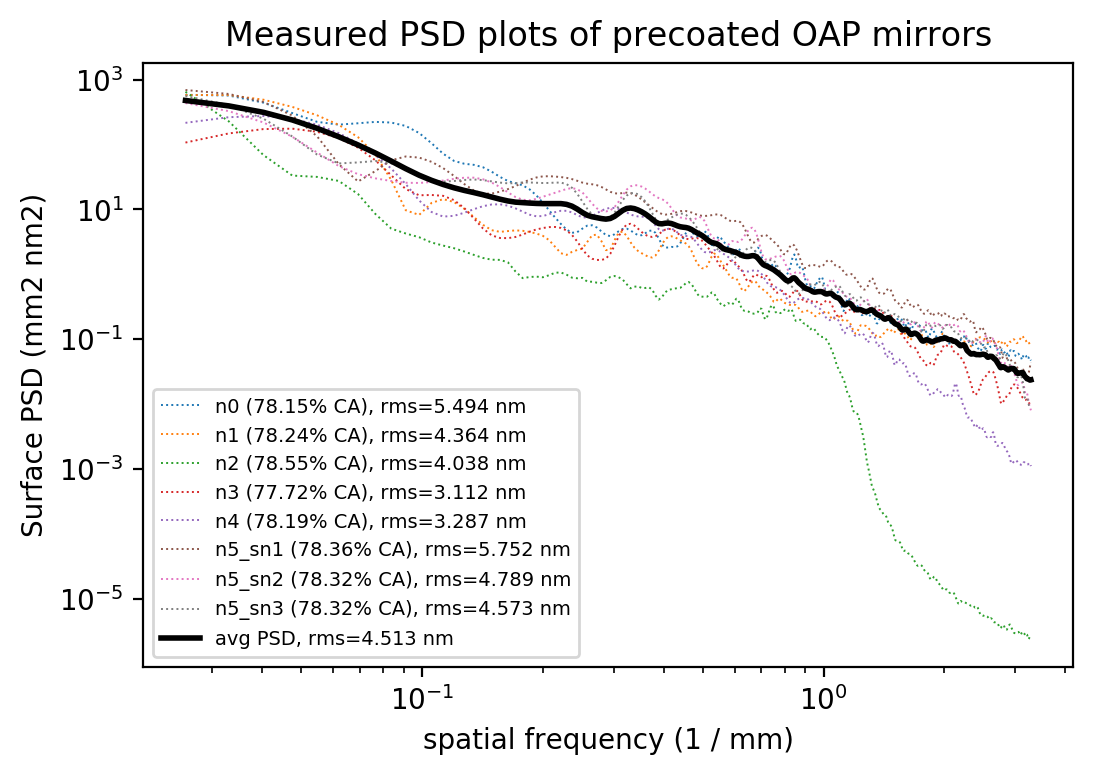

In [40]:
plt.figure(dpi=200)
ca_value = []
for ns in range(0,ntot):
    name = n_oap_list[ns]
    cap_val = diam_ca[name]/full_diam*100
    plt.loglog(k_new, psd1D_data[ns,:], ':', label='{0} ({1:.2f}% CA), rms={2:.3f}'.format(name, cap_val, np.sqrt(surf_var[name])), linewidth=0.7)
    ca_value.append(cap_val)
plt.loglog(k_new, avg_psd1d_norm_var, 'k', label='avg PSD, rms={0:.3f}'.format(avg_tot_rms), linewidth=2)  
#plt.loglog(k_new, red_avg_psd1d_norm_var, 'r', label='reduced avg PSD, rms={0:.3f}'.format(red_avg_tot_rms), linewidth=2)  
plt.title('Measured PSD plots of precoated OAP mirrors')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({0})'.format(kval1D[name].unit))
plt.ylabel('Surface PSD ({0})'.format(psd1D_data.unit)) 

Text(0, 0.5, 'normalized surface PSD (mm2)')

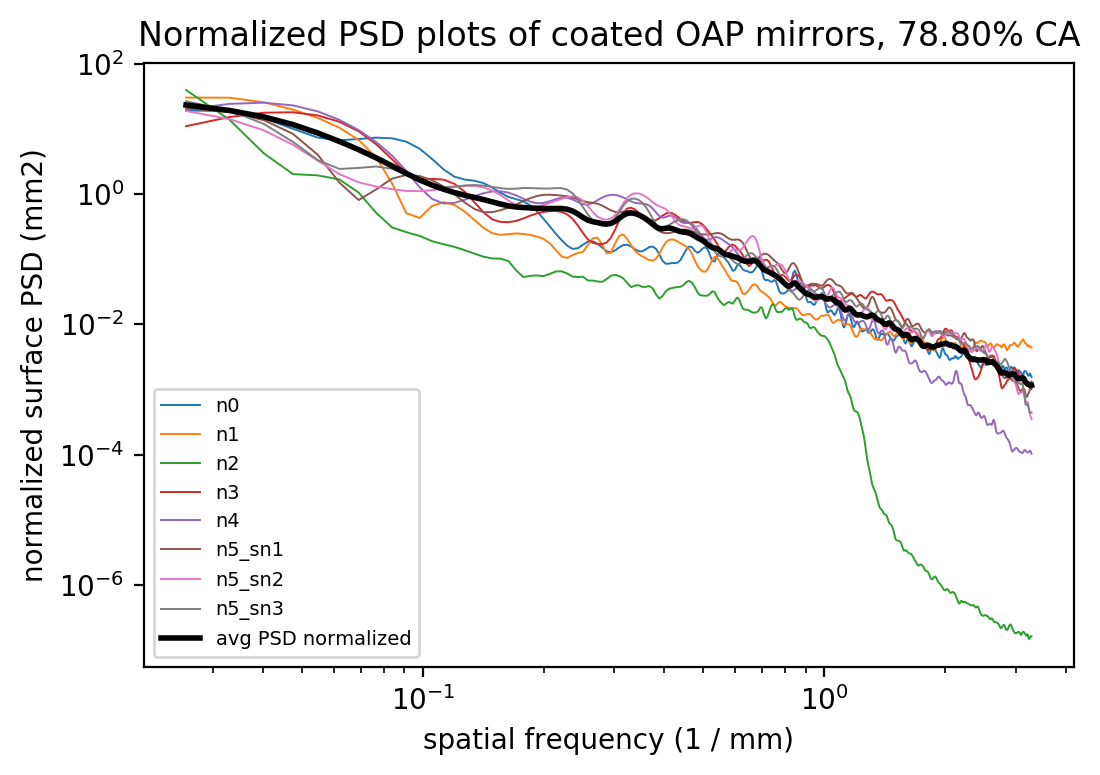

In [38]:
plt.figure(dpi=200)
for ns in range(0,ntot):
    name = n_oap_list[ns]
    plt.loglog(k_new, psd1D_norm[ns,:], label='{}'.format(name), linewidth=0.7)
plt.loglog(k_new, avg_psd1d_norm, 'k', label='avg PSD normalized', linewidth=2)  
#plt.loglog(k_new, red_avg_psd1d_norm, 'r', label='reduced avg PSD normalized', linewidth=2)
plt.title('Normalized PSD plots of coated OAP mirrors')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval1D[name].unit))
plt.ylabel('normalized surface PSD ({})'.format(psd1D_norm.unit)) 

## Modelling the PSD
Finding alpha, beta, l0, L0

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

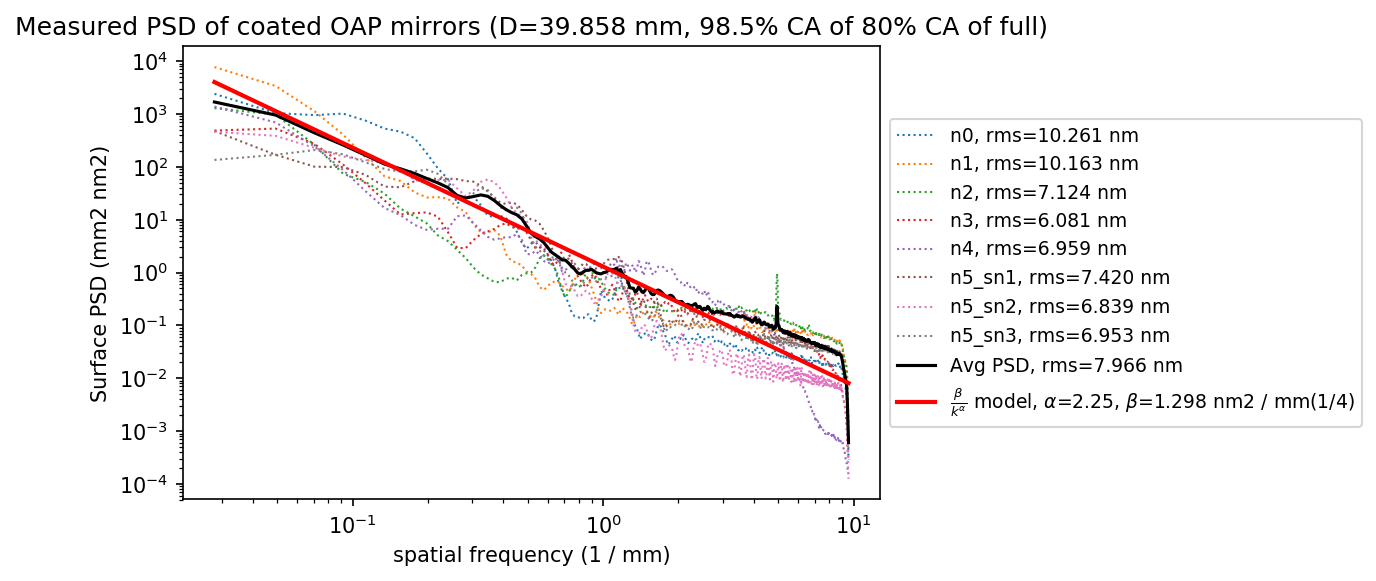

In [251]:
1/40 to 1/10# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
#klim = 0.15
klim = np.amin(k_new.value)
kfit = np.zeros((k_npts))
for kn in range(0,k_npts):
    kfit[kn] = np.abs(k_new[kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = k_new[klim_ind:k_npts]

a2 = 2.25 # estimate for OAP
b2 = psd.calc_beta(a2, avg_tot_var, opt_parms['diam_ca'], avg_npix_diam)
a2_fit = b2/(k_range**a2)
a2_fit1 = b2/((avg_tot_var**a2)*(k_range**a2))

# plotting
plt.figure(dpi=150)
for ns in range(0,ntot):
   opt_name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(opt_name, np.sqrt(var_1[opt_name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.title('Measured PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

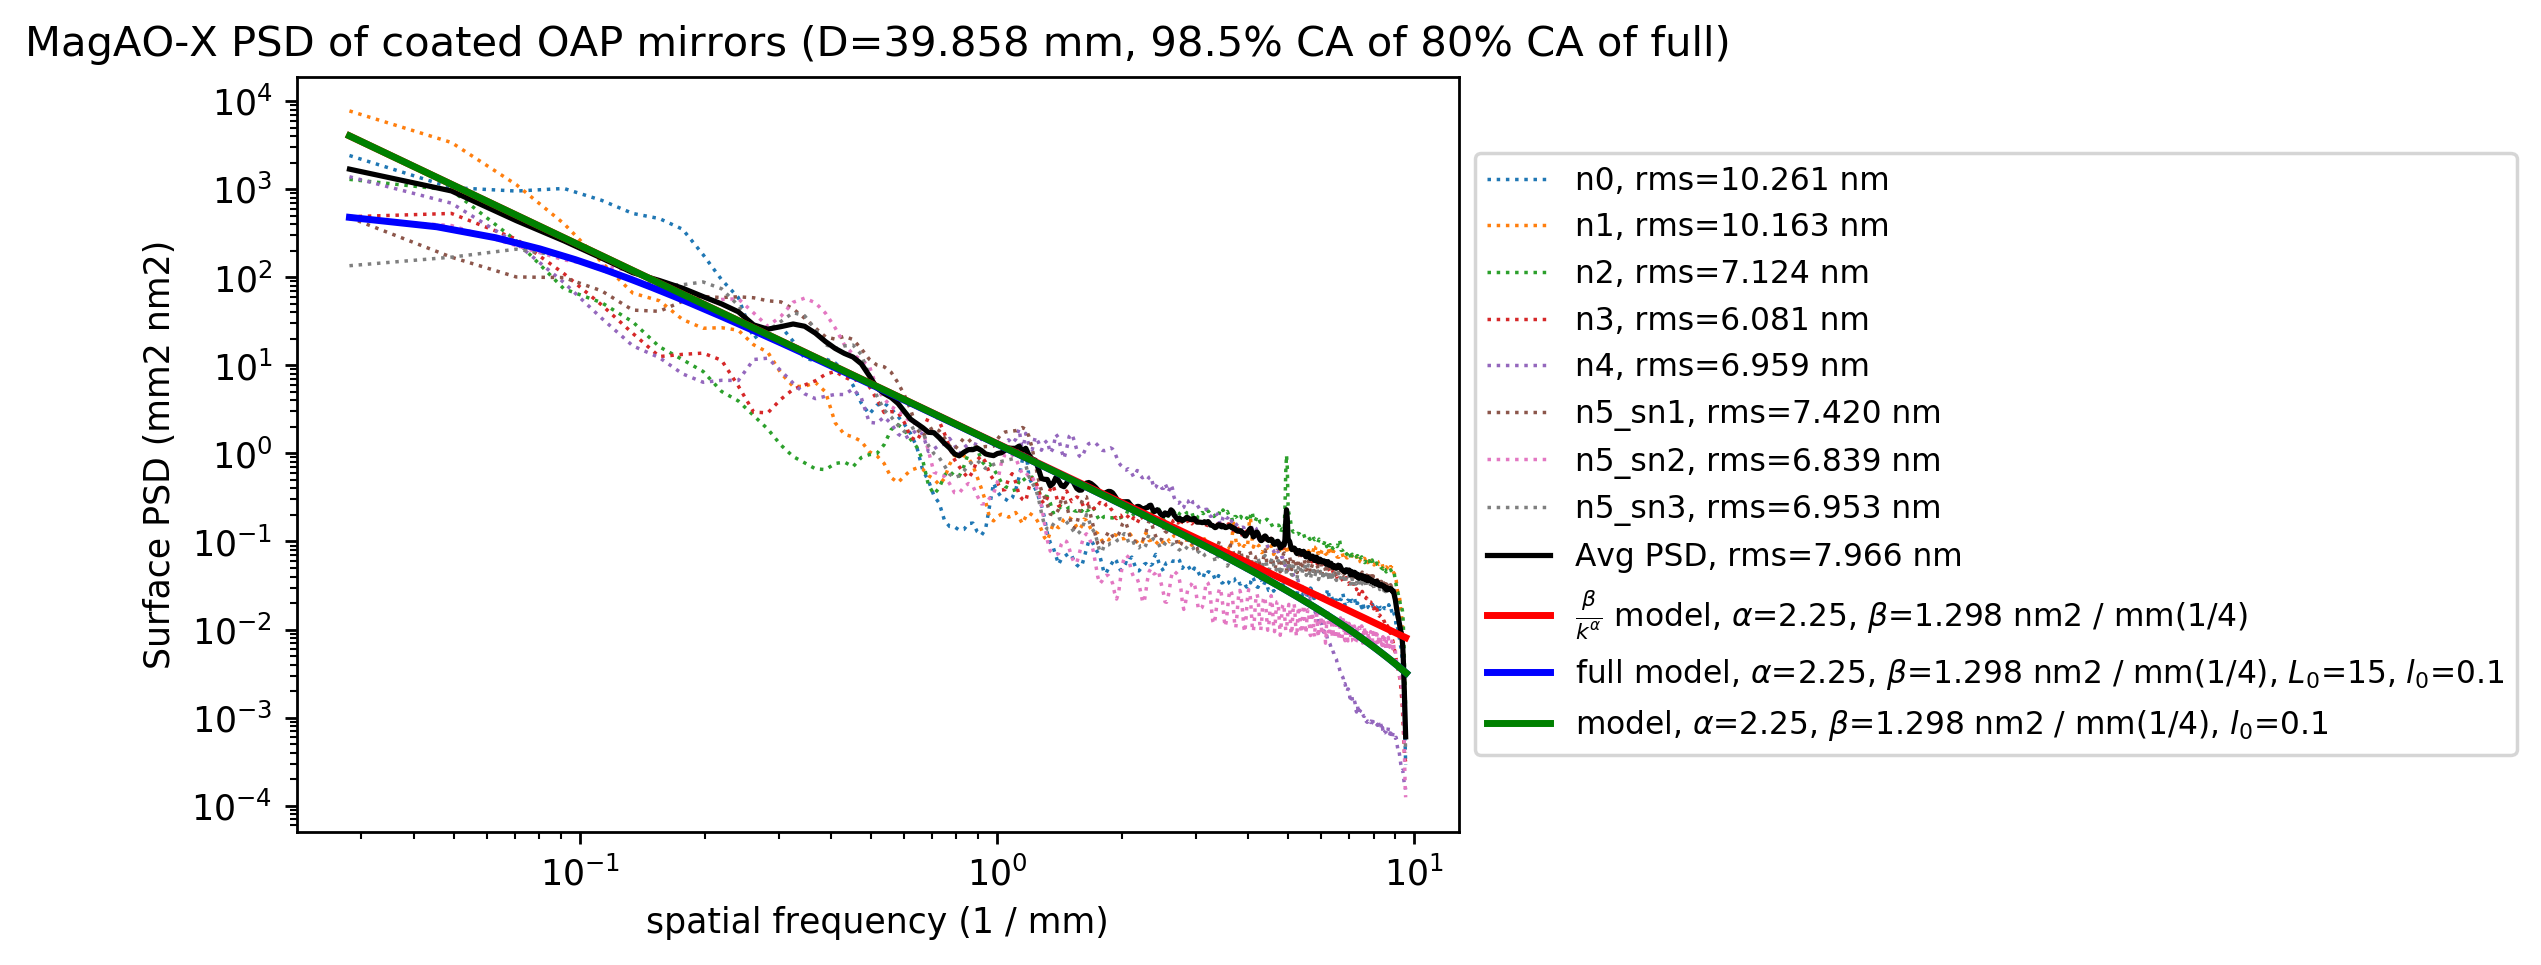

In [254]:
k_ul = 1/(2*opt_parms['diam_ca']/opt_parms['npix_diam_ca'])
k_far = np.linspace(klim, k_ul.value+0, k_npts+100)
L0 = 15
lo = 0.1
psd_full = b2 * np.exp(-(k_far*lo)**2) / ( ( (L0**-2) + (k_far**2) ) ** (a2*.5))
psd_fit = (b2/(k_far**a2)) * np.exp(-(k_far * lo)**2)

# plotting
plt.figure(dpi=250)
for ns in range(0,ntot):
   name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
#plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
plt.loglog(k_far, psd_full, 'b', label='full model, {}={}, {}={:.3f}, {}={}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$L_{0}$',L0, r'$l_{0}$', lo), linewidth=2.0)
plt.loglog(k_far, psd_fit, 'g', label='model, {}={}, {}={:.3f}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$l_{0}$', lo), linewidth=2.0)
plt.title('MagAO-X PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

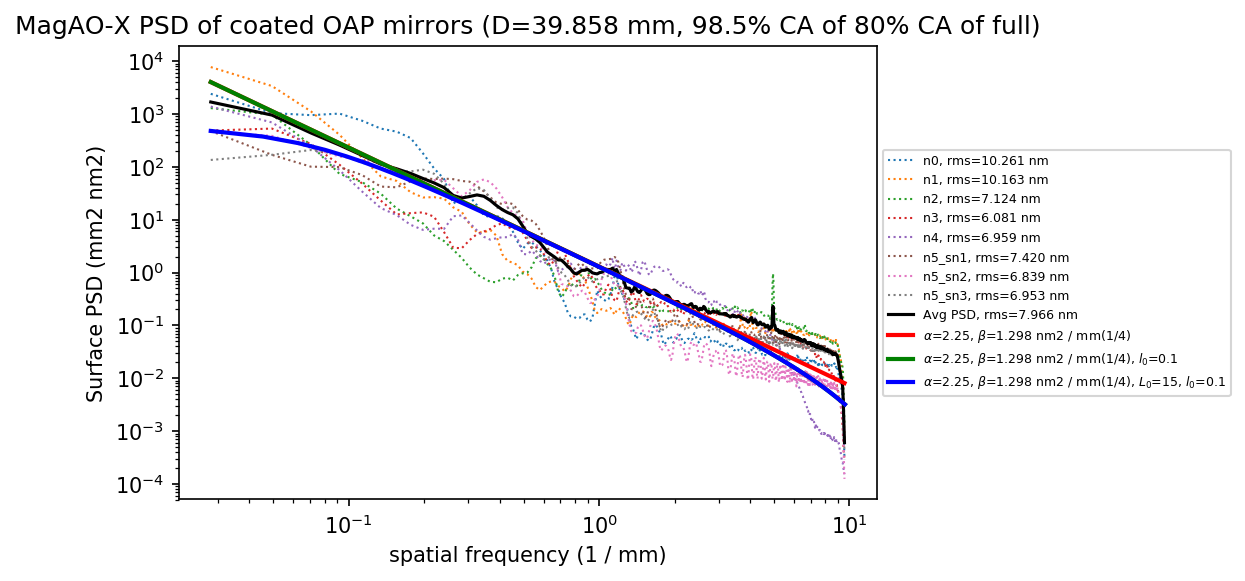

In [258]:
# plotting
plt.figure(dpi=150)
for ns in range(0,ntot):
   name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
#plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.loglog(k_range, a2_fit, 'r', label='{}={}, {}={:.3f}'.format(r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
plt.loglog(k_far, psd_fit, 'g', label='{}={}, {}={:.3f}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$l_{0}$', lo), linewidth=2.0)
plt.loglog(k_far, psd_full, 'b', label='{}={}, {}={:.3f}, {}={}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$L_{0}$',L0, r'$l_{0}$', lo), linewidth=2.0)
plt.title('MagAO-X PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':6},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

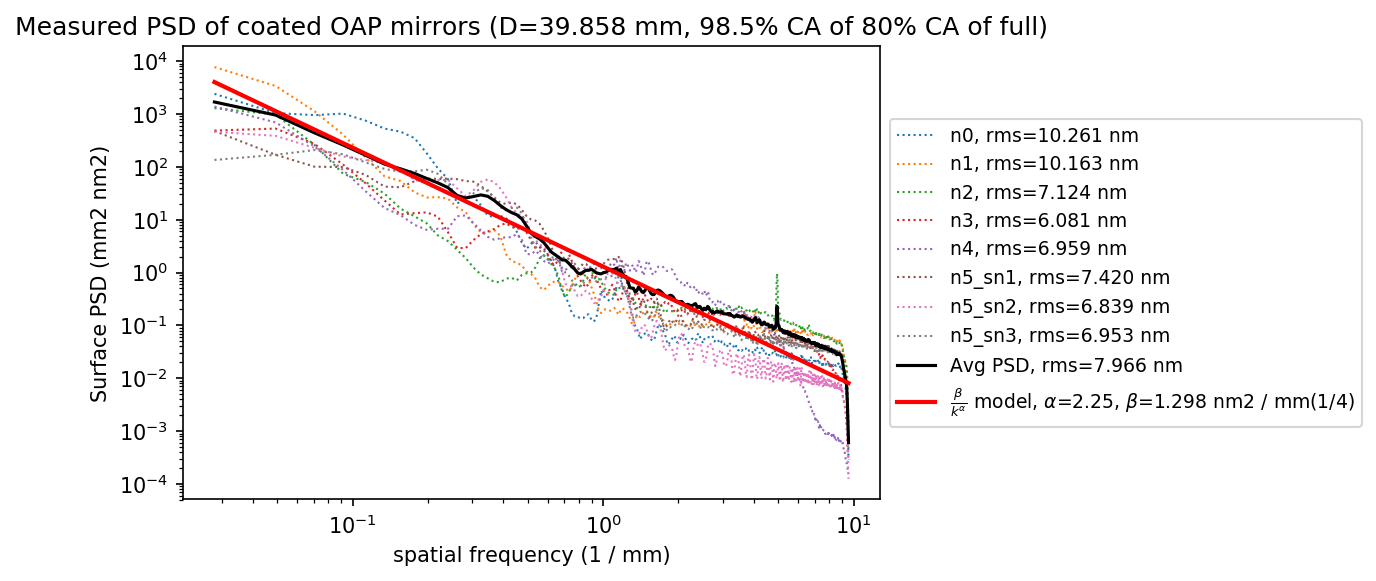

In [243]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
#klim = 0.15
klim = np.amin(k_new.value)
kfit = np.zeros((k_npts))
for kn in range(0,k_npts):
    kfit[kn] = np.abs(k_new[kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = k_new[klim_ind:k_npts]

a2 = 2.25 # estimate for OAP
b2 = psd.calc_beta(a2, avg_tot_var, opt_parms['diam_ca'], avg_npix_diam)
a2_fit = b2/(k_range**a2)
a2_fit1 = b2/((avg_tot_var**a2)*(k_range**a2))

# plotting
plt.figure(dpi=150)
for ns in range(0,ntot):
   opt_name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(opt_name, np.sqrt(var_1[opt_name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.title('Measured PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

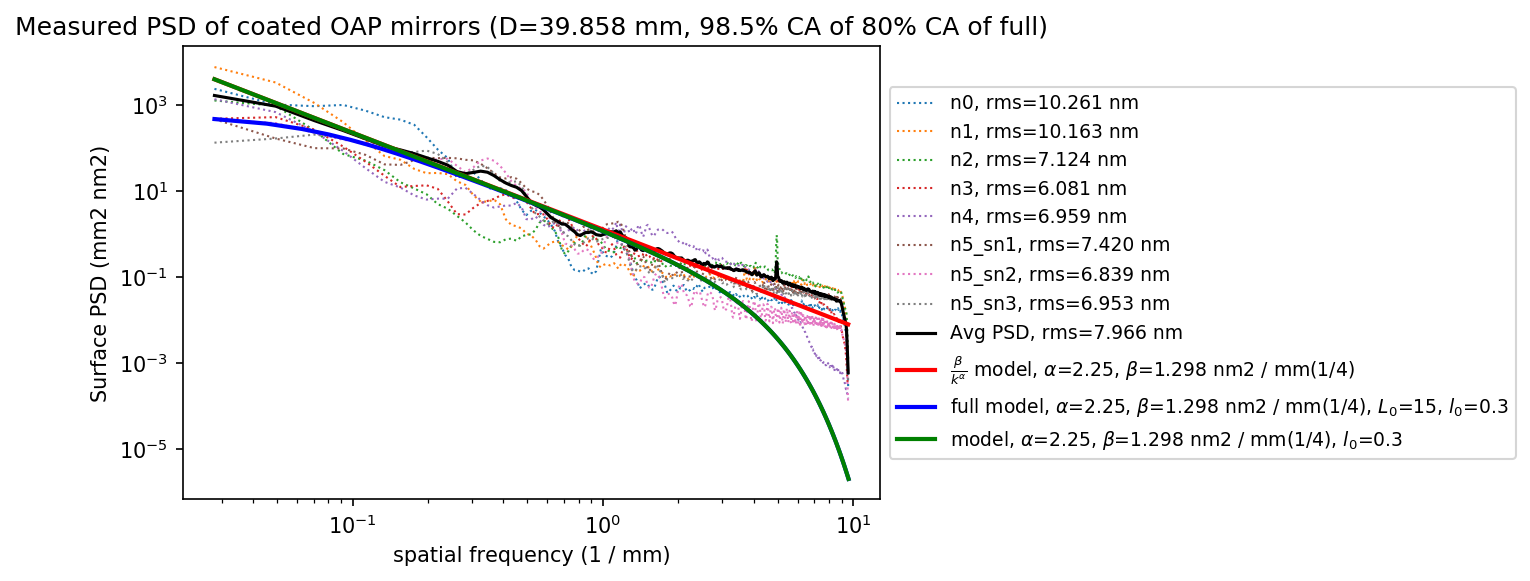

In [246]:
k_ul = 1/(2*opt_parms['diam_ca']/opt_parms['npix_diam_ca'])
k_far = np.linspace(klim, k_ul.value+0, k_npts+100)
L0 = 15
lo = 0.3
psd_full = b2 * np.exp(-(k_far*lo)**2) / ( ( (L0**-2) + (k_far**2) ) ** (a2*.5))
psd_fit = (b2/(k_far**a2)) * np.exp(-(k_far * lo)**2)

# plotting
plt.figure(dpi=150)
for ns in range(0,ntot):
   name = n_oap_list[ns]
   plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
#plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}, {}={:.3f}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2, r'$\beta$',b2), linewidth=2.0)
plt.loglog(k_far, psd_full, 'b', label='full model, {}={}, {}={:.3f}, {}={}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$L_{0}$',L0, r'$l_{0}$', lo), linewidth=2.0)
plt.loglog(k_far, psd_fit, 'g', label='model, {}={}, {}={:.3f}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$l_{0}$', lo), linewidth=2.0)
plt.title('Measured PSD of coated OAP mirrors (D={0:.3f}, {1}% CA of 80% CA of full)'.format(opt_parms['diam_ca'], opt_parms['ca']))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

# Reference code
Exploration type stuff

## Inspect the .datx data
Check their sizes and convert to .fits for ds9 inspection.

OAP0 has shape (307, 307) with lateral resolution 0.0001311
OAP1 has shape (312, 312) with lateral resolution 0.0001295
OAP2 has shape (508, 508) with lateral resolution 0.0000789
OAP3 has shape (261, 262) with lateral resolution 0.0001530
OAP4 has shape (258, 259) with lateral resolution 0.0001564
OAP5_SN01 has shape (264, 263) with lateral resolution 0.0001519
OAP5_SN02 has shape (264, 263) with lateral resolution 0.0001518
OAP5_SN03 has shape (264, 264) with lateral resolution 0.0001518


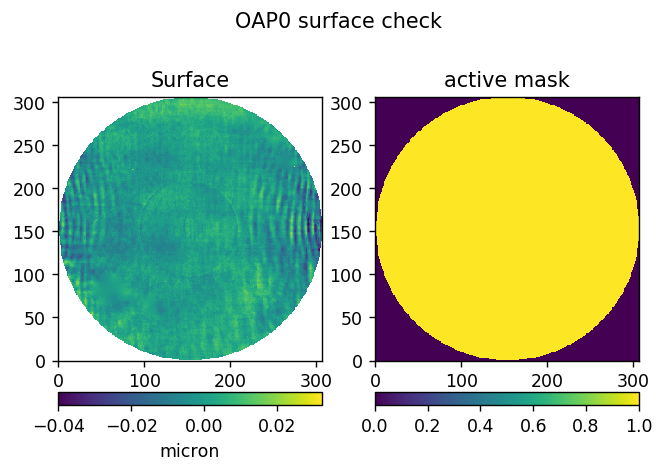

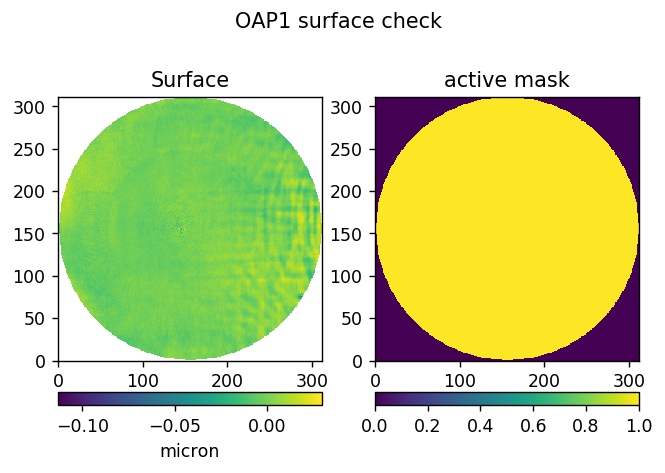

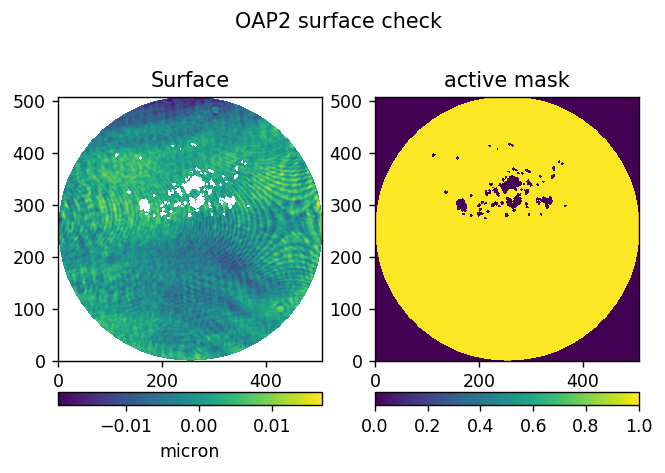

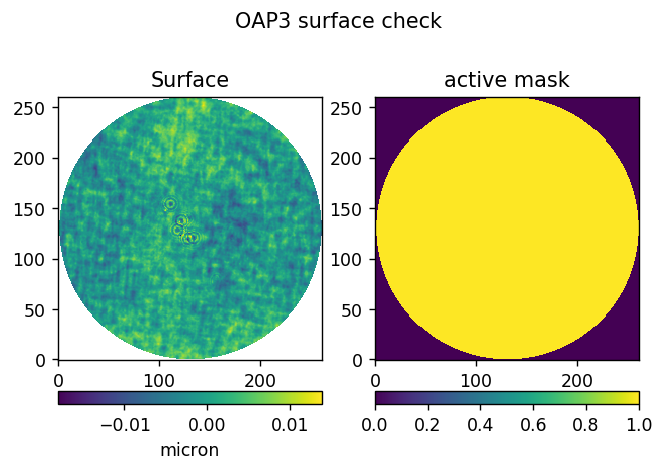

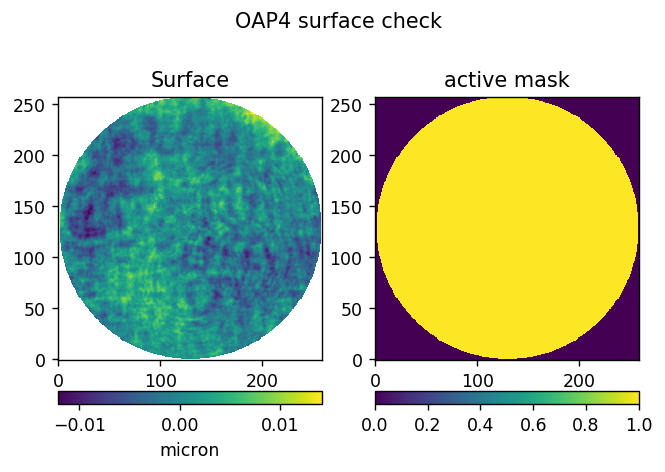

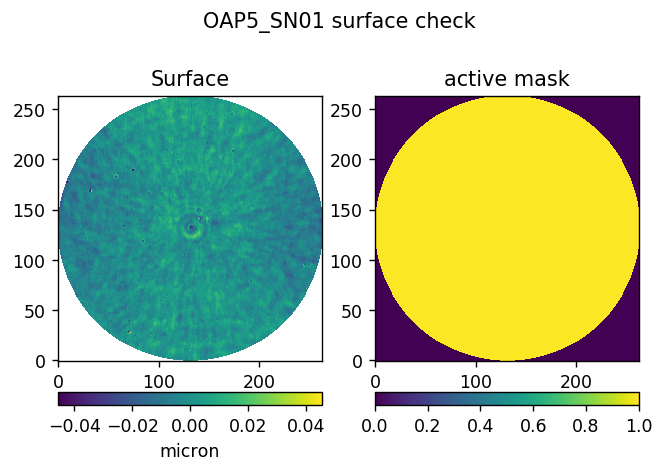

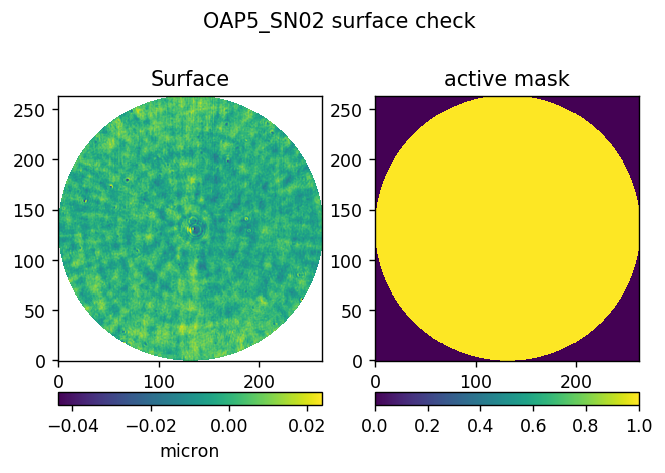

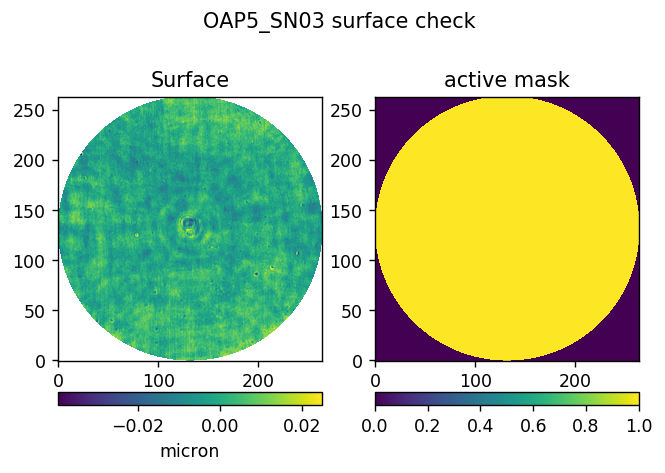

In [3]:
# plot all the data for the surfaces for quick inspection
# mass convert the .datx files to .fits 
folder = 'zygo_data/oaps/oap_precoated/'
oap_labels =  ('0', '1', '2', '3', '4', '5_SN01', '5_SN02', '5_SN03')
#oap_labels =  ('0')
for surface_name in oap_labels:
    datx_file = 'OAP{0}_Pre-Coat'.format(surface_name)
    #print(folder+datx_file+'.datx')
    s0, m0, sp0 = psd.get_map_datx(folder+datx_file+'.datx')
    print('OAP{0} has shape {1} with lateral resolution {2:.7f}'.format(surface_name, np.shape(s0), sp0['lateral_res']))
    sn0 = psd.sn_map(s0, m0)
    supertitle = 'OAP{} surface check'.format(surface_name)
    psd.show2plots(supertitle, sn0, 'Surface', m0.astype(int), 'active mask', set_dpi=125)
    
    # write to file
    #header = fits.Header()
    #fits.writeto(folder+datx_file+'_surf.fits', s0, header, overwrite=True)
    #fits.writeto(folder+datx_file+'_mask.fits', m0, header, overwrite=True)
    psd.write2fits(s0, m0, sp0, folder+datx_file)

## Set OAP centers for cropping data
Convert these to .fits files too

OAP0 has shape (304, 304) with diameter 39.861 mm and lateral resolution 0.0001311 m/pix
OAP1 has shape (308, 308) with diameter 39.898 mm and lateral resolution 0.0001295 m/pix
OAP2 has shape (506, 506) with diameter 39.908 mm and lateral resolution 0.0000789 m/pix
OAP3 has shape (258, 258) with diameter 39.474 mm and lateral resolution 0.0001530 m/pix
OAP4 has shape (254, 254) with diameter 39.721 mm and lateral resolution 0.0001564 m/pix
OAP5_SN01 has shape (262, 262) with diameter 39.789 mm and lateral resolution 0.0001519 m/pix
OAP5_SN02 has shape (262, 262) with diameter 39.765 mm and lateral resolution 0.0001518 m/pix
OAP5_SN03 has shape (262, 262) with diameter 39.765 mm and lateral resolution 0.0001518 m/pix


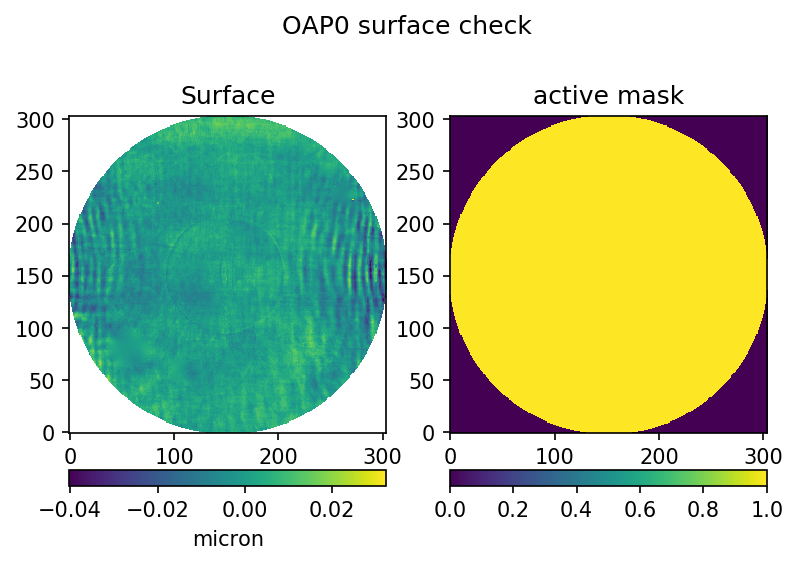

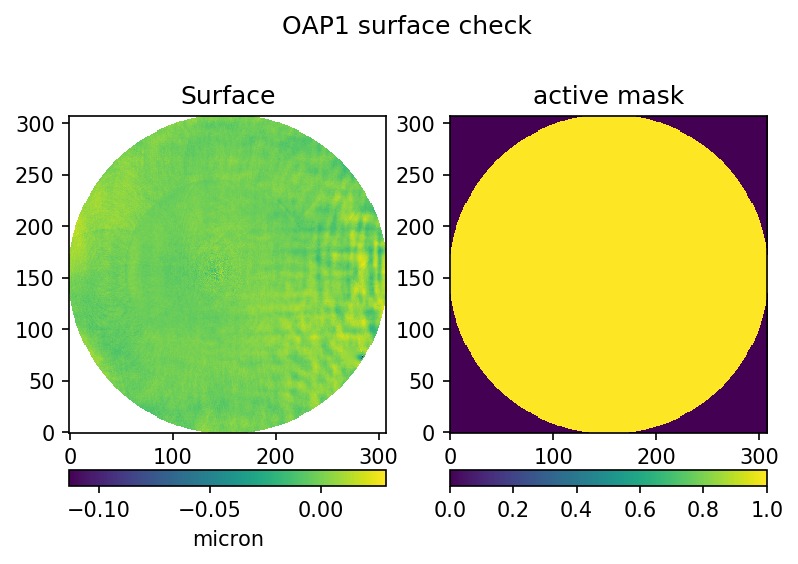

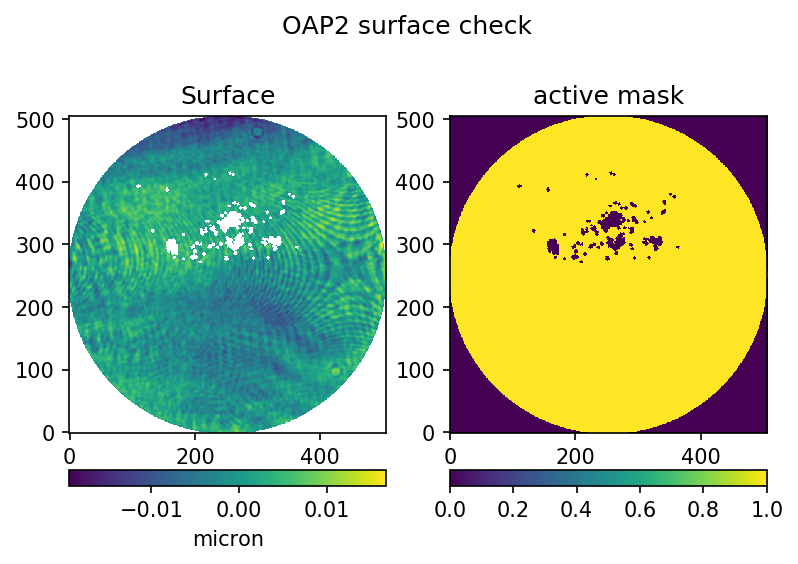

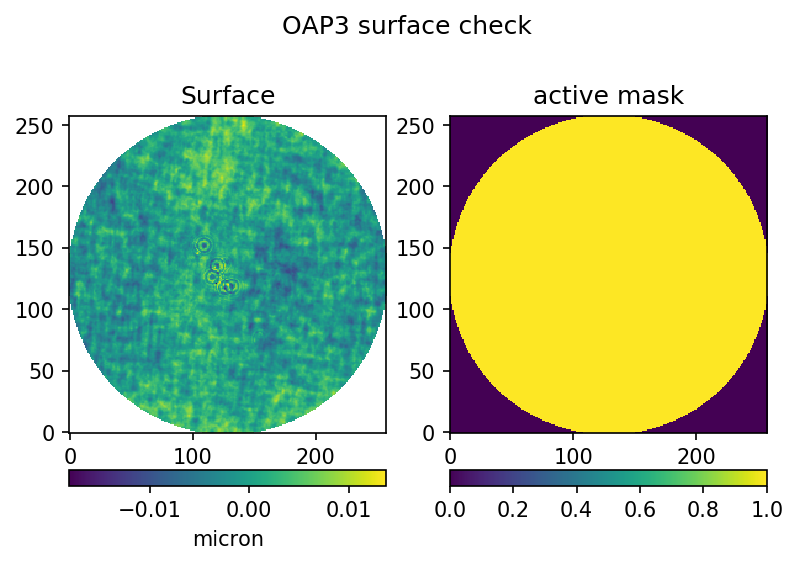

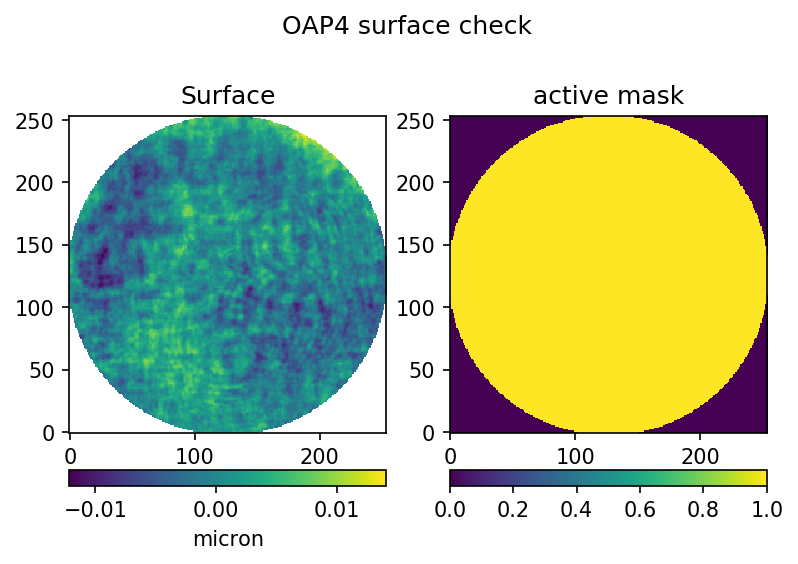

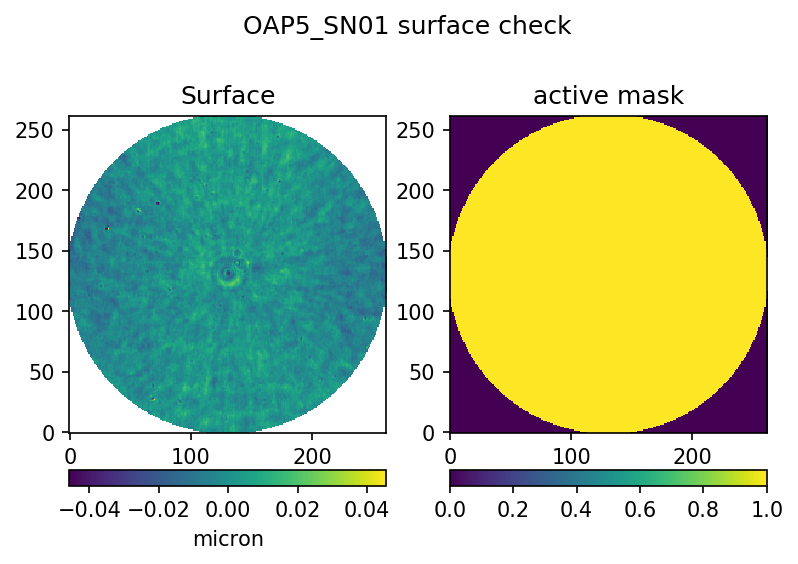

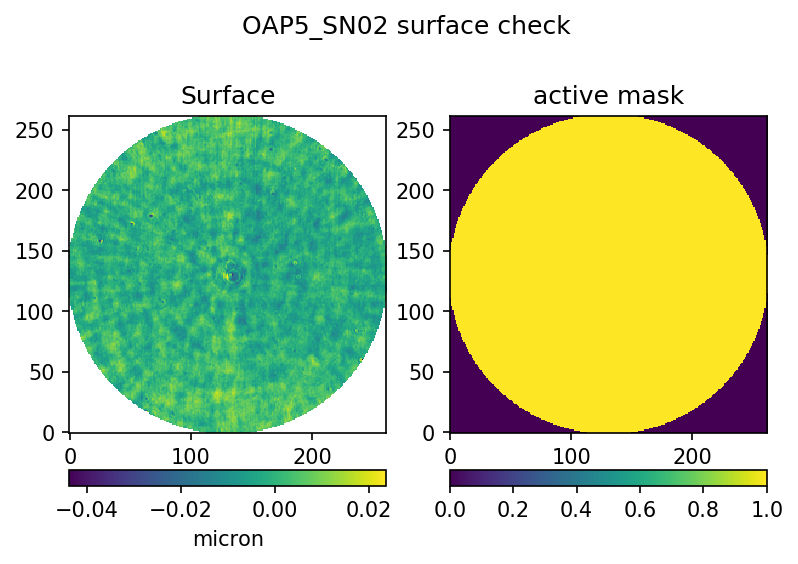

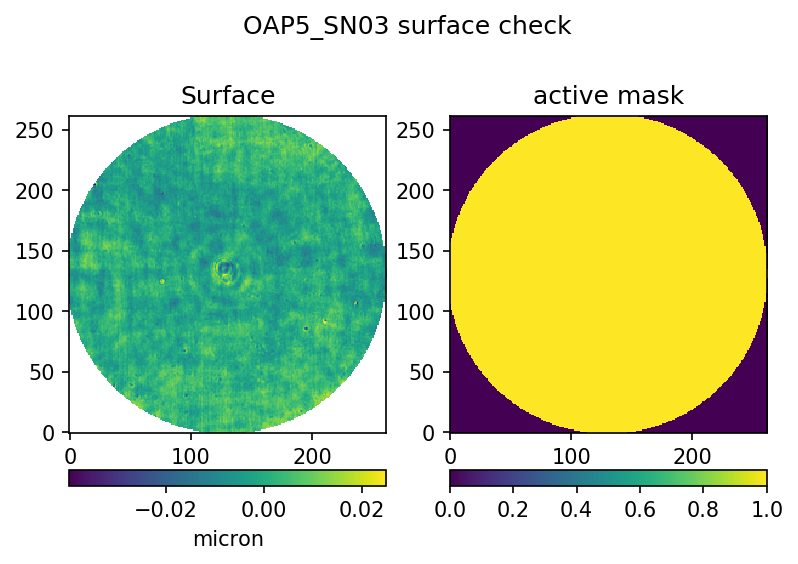

In [6]:
# oap centers found; open .datx file, crop to center, and convert to .fits
# order is in (Y, X). On DS9, it appears as (X,Y)
oap_center = [(154, 154), #oap0
              (156, 156), #oap1
              (255, 255), #oap2
              (131, 131), #oap3
              (130, 130), #oap4
              (132, 132), #oap5_sn1
              (132, 132), #oap5_sn2
              (132, 133)] #oap5_sn3
oap_npix_radius = [152, 154, 253, 129, 127, 131, 131, 131]

folder = 'zygo_data/oaps/oap_precoated/'
oap_labels =  ('0', '1', '2', '3', '4', '5_SN01', '5_SN02', '5_SN03')

for noap in range(0, len(oap_labels)):
    datx_file = folder+'uncentered_data/OAP{0}_Pre-Coat'.format(oap_labels[noap])
    s0, m0, sp0 = psd.get_map_datx(datx_file+'.datx')
    center = oap_center[noap]
    npix_radius = oap_npix_radius[noap]
    censurf = s0[center[0]-npix_radius:center[0]+npix_radius, center[1]-npix_radius:center[1]+npix_radius]
    cenmask = m0[center[0]-npix_radius:center[0]+npix_radius, center[1]-npix_radius:center[1]+npix_radius]
    sp0['diameter_mm'] = np.shape(censurf)[0]*sp0['lateral_res']*1e3*u.mm # overwrite this number for the headers
    filename = folder+'oap{0}_centered'.format(oap_labels[noap])
    psd.write2fits(censurf, cenmask, sp0, filename)
    
    # size print-out verification
    print('OAP{0} has shape {1} with diameter {2:.3f} and lateral resolution {3:.7f} m/pix'.format(oap_labels[noap], np.shape(censurf), sp0['diameter_mm'], sp0['lateral_res']))
    
    # print out the surface and mask
    sn0 = psd.sn_map(s0, m0)
    censurf_nan = sn0[center[0]-npix_radius:center[0]+npix_radius, center[1]-npix_radius:center[1]+npix_radius]
    supertitle = 'OAP{} surface check'.format(oap_labels[noap])
    psd.show2plots(supertitle, censurf_nan, 'Surface', cenmask.astype(int), 'active mask')

## Undersize the data and inspect for bad data.
Interpolate (cubic) to fill in the missing data.

In [14]:
# check if there is any missing data and convert the .fits files to the aperture size desired
#lat_res = 5.21705187566112e-5 # meters/pix; hard-coded from data. Works because all data is same size. Will not work if the files have different values.
#npix_radius = 388 # hard-coded from ds9 data
#side_len = npix_radius*2
undersize = 0.985 # personally chosen
full_diam = 50*u.mm

# declare surface parameters
surf_parms = {}

# open the files
folder = 'zygo_data/oaps/oap_precoated/'
oap_labels =  ('0', '1', '2', '3', '4', '5_SN01', '5_SN02', '5_SN03')

for noap in range(0, len(oap_labels)):
    filename = folder+'oap{0}_centered'.format(oap_labels[noap])
    mask_data, mask_header = fits.getdata(filename+'_mask.fits', header=True)
    surf_data, surf_header = fits.getdata(filename+'_surf.fits', header=True)
    
    # fill in the surface parameters
    surf_parms['wavelength'] = surf_header['wavelen']
    surf_parms['units'] = surf_header['units']
    surf_parms['lateral_res'] = surf_header['latres']
    surf_parms['diameter_mm'] = surf_parms['lateral_res']*npix_radius*2*undersize*1e3*u.mm
    
    # build the clear aperture range
    side_len = np.shape(mask_data)[0]
    ap_clear = np.zeros((side_len, side_len), dtype=np.uint8)
    ca_coords = draw.circle(side_len/2, side_len/2, radius=(side_len/2)*undersize)
    ap_clear[ca_coords] = True
    
    undersize_diam = surf_parms['lateral_res']*side_len*undersize*1e3 * u.mm
    actual_ca = undersize_diam/full_diam
    
    print('OAP{0} diameter: {1:.3f} at {2:.2f}% CA'.format(oap_labels[noap], undersize_diam, actual_ca*100,))
    
    # check what is going on inside the aperture
    if (np.where(mask_data[ca_coords]==0))[0].size >0: # we got bad data
        n_badpix = np.shape(np.where(mask_data[ca_coords]==0))[1]
        print('OAP{0} has bad data: {1} bad pixels present. Performing interpolation to fill in bad data.\n'.format(oap_labels[noap], n_badpix))
        new_surf = psd.fill_surface(surf_data, mask_data, ap_clear, ca_coords)
        new_filename = folder+'oap{0}interp_centered_{1}CA'.format(oap_labels[noap], str(undersize*100))
    else:
        print('OAP{0} has all good data\n'.format(oap_labels[noap]))
        new_surf = surf_data*ap_clear
        new_filename = folder+'oap{0}_centered_{1}CA'.format(oap_labels[noap], str(undersize*100))
        
    # write new fits file data
    #psd.write2fits(new_surf, ap_clear, surf_parms, new_filename)

OAP0 diameter: 39.263 mm at 78.53% CA
OAP0 has all good data

OAP1 diameter: 39.300 mm at 78.60% CA
OAP1 has all good data

OAP2 diameter: 39.309 mm at 78.62% CA
OAP2 has bad data: 3945 bad pixels present. Performing interpolation to fill in bad data.

OAP3 diameter: 38.882 mm at 77.76% CA
OAP3 has all good data

OAP4 diameter: 39.125 mm at 78.25% CA
OAP4 has all good data

OAP5_SN01 diameter: 39.192 mm at 78.38% CA
OAP5_SN01 has all good data

OAP5_SN02 diameter: 39.169 mm at 78.34% CA
OAP5_SN02 has all good data

OAP5_SN03 diameter: 39.169 mm at 78.34% CA
OAP5_SN03 has all good data



## Checking interpolation code
This is all pre-built in the "fill_surface" function.

In [176]:
# let's probe the bad OAP data
folder = 'zygo_data/oaps/oap_coated/'
oap_labels =  ('0', '1', '2', '3', '4', '5_sn1', '5_sn2', '5_sn3')

t_oap = 5 # pre-known
filename = folder+'oap{0}_centered'.format(oap_labels[t_oap])
mask_data, mask_header = fits.getdata(filename+'_mask.fits', header=True)
surf_data, surf_header = fits.getdata(filename+'_surf.fits', header=True)
side_len = np.shape(surf_data)[0]

ind, imask = psd.interp_mask(ca_coords, mask_data)
working_data = imask*surf_data*ap_clear
values = working_data[imask.astype(bool)==True]
yy, xx = np.indices(working_data.shape)
mask_points = np.argwhere(imask==1)

grid_z2 = interpolate.griddata(mask_points, values, (yy, xx), method='cubic')

In [177]:
plane = np.ones(mask_data.shape)
plane[imask==0] = np.nan
nan_data = plane*surf_data*ap_clear
print('Compare output data before and after interpolation')
for n in range(0, np.shape(ind)[0]):
    print('Index {0} value: {1:.5f}   |   {2:.5f}'.format(ind[n], nan_data[ind[n][0]][ind[n][1]], grid_z2[ind[n][0]][ind[n][1]]))

print('control index check')
ctrl_ind = [[388, 388], [400,500]]
for n in range(0, np.shape(ctrl_ind)[0]):
    print('Index {0} value: {1:.5f}   |   {2:.5f}'.format(ctrl_ind[n], nan_data[ctrl_ind[n][0]][ctrl_ind[n][1]], grid_z2[ctrl_ind[n][0]][ctrl_ind[n][1]]))

Compare output data before and after interpolation
Index [383, 722] value: nan   |   0.00398
Index [384, 722] value: nan   |   -0.00894
Index [399, 745] value: nan   |   0.01214
Index [400, 714] value: nan   |   0.02104
Index [407, 700] value: nan   |   -0.00359
Index [410, 679] value: nan   |   0.00272
Index [412, 721] value: nan   |   0.02204
Index [415, 670] value: nan   |   0.00313
Index [417, 706] value: nan   |   0.00979
Index [418, 711] value: nan   |   0.01136
Index [419, 695] value: nan   |   -0.03475
Index [421, 671] value: nan   |   0.01384
Index [433, 727] value: nan   |   0.02870
Index [434, 727] value: nan   |   0.00484
Index [437, 735] value: nan   |   0.02067
Index [442, 716] value: nan   |   0.00595
Index [442, 718] value: nan   |   -0.01245
Index [447, 735] value: nan   |   -0.00184
Index [453, 667] value: nan   |   0.00179
Index [456, 733] value: nan   |   0.00175
Index [458, 732] value: nan   |   -0.02352
Index [459, 686] value: nan   |   0.00471
Index [459, 732] va

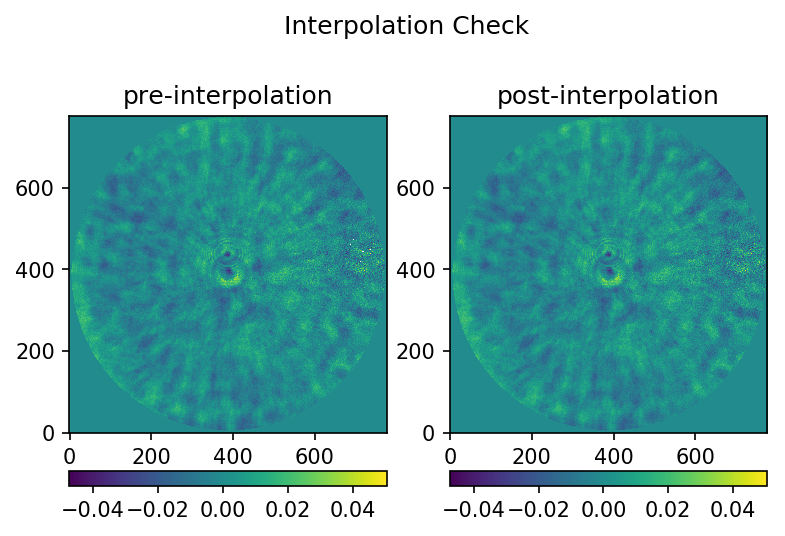

In [157]:
psd.show2plots('Interpolation Check', nan_data, 'pre-interpolation', grid_z2, 'post-interpolation')